In [1]:
import time
start_time=time.time()

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import json
import cmasher as cmr
import seaborn as sns
import sys
import pylab as pl
import pandas as pd


from astropy.io import fits
from astropy.utils.misc import JsonCustomEncoder
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve_fft

from turbustat.simulator import make_ppv
from spectral_cube import SpectralCube  
import lmfit

sys.path.insert(1, 'C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules')  
from turb_utils import make_extended, make_3dfield
import strucfunc
import bfunc
import bplot_mod


In [2]:
a = {}

for k in range(6):
    a[k+1] = np.round(np.linspace(1,5,15)[k],2)
    
a[6]

2.43

In [3]:
k = np.linspace(1,5,15)

In [4]:
k[14]

5.0

In [6]:
kappa = {}

sig_E = 2
delta_k = 1
n = 15

k = np.linspace(1,5,n)
r0 = 32.0
N = 256


for j in range(n):
######cube
    k = np.linspace(1,5,n)[j]
    ## 3D tapered velocity map
    velocity = make_3dfield(
        N,
        ellip=0.5,
        theta=45,
        correlation_length=r0,  
        powerlaw=k,
        randomseed=2021_10_08)* u.km / u.s  
    
    ## Emissivity fluctuations
    density = make_3dfield(N, 
                       powerlaw=k + delta_k, 
                       amp=1.,
                       ellip=0.5,
                       theta=45,
                       correlation_length=r0,  
                       randomseed=328764) * u.cm**-3  
    density = (density-density.mean())/density.std()
    emissivity = np.exp(sig_E * density)* u.cm**-3

    ##Tapered Cube
    cube_hdu = make_ppv(velocity, emissivity, los_axis=0,
                    T=10000 * u.K, chan_width=0.5 * u.km / u.s,
                    v_min=-20 * u.km / u.s,
                    v_max=20 * u.km / u.s)  

    cube = SpectralCube.read(cube_hdu)  
###########structure function
    sf = strucfunc.strucfunc_numba_parallel(cube.moment1().value, wmap=cube.moment0().value, dlogr=0.05)
###########confidence intervals
    mask = np.array(sf["N pairs"]) > 0
    B = np.array(sf["Unweighted B(r)"])[mask]
    r = 10**np.array(sf["log10 r"])[mask]
    box_size = 362
    pc = 1
    pix = 1
    pc_per_arcsec = pc

    model = lmfit.Model(bfunc.bfunc03s)
    model.param_names
    
    # Correlation length between 1/10 and 2 x box_size
    model.set_param_hint("r0", value=0.1 * box_size, min=0.01 * box_size, max=2.0 * box_size)
    # sig2 between 1/4 and 2 x max value of B(r)
    model.set_param_hint("sig2", value=0.5 * B.max(), min=0.25 * B.max(), max=2.0 * B.max())
    # m between 1/2 and 5/3
    model.set_param_hint("m", value=1, min=0.5, max=1.5)
    #Seeing RMS between 0.5 and 1.5 arcsec
    #model.set_param_hint(
    #    "s0", value=0.85 * pc_per_arcsec, min=0.5 * pc_per_arcsec, max=1.5 * pc_per_arcsec
    #)
    # Seeing pegged at ZERO
    model.set_param_hint(
        "s0", value=0.0 * 1, vary=False,
    )

    # Noise cannot be much larger than smallest B(r)
    model.set_param_hint("noise", value=0.5 * B.min(), min=0.0, max=3 * B.min())
    # box_size is fixed
    # model.set_param_hint("box_size", value=box_size, vary=False)

    relative_uncertainty = 0.085
    weights = 1.0 / (relative_uncertainty * B)
    large_scale = r > 0.5* box_size
    weights[large_scale] /= 2.0
    #weights[:1] /= 2.0

    to_fit = r <= 0.5* box_size
    #to_fit = ~large_scale
    result = model.fit(B[to_fit], weights=weights[to_fit], r=r[to_fit])

    emcee_kws = dict(
        steps=25000, burn=500, thin=50, is_weighted=True, progress=False, workers=16
    )
    emcee_params = result.params.copy()
    # emcee_params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2.0))

    result_emcee = model.fit(
        data=B[to_fit],
        r=r[to_fit],
        weights=weights[to_fit],
        params=emcee_params,
        method="emcee",
        nan_policy="omit",
        fit_kws=emcee_kws,
    )
####save data

    ms2 = np.percentile(result_emcee.flatchain['m'],[2.5, 97.5])
    ms2p = ms2[1]-result.params['m'].value
    ms2m = result.params['m'].value-ms2[0]

    kappa[j] = [k, result.params['m'].value, ms2p, ms2m]
    
#kappa

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple se

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 500;
tau: [2412.11318375  953.78185858 2138.98764751 2465.46089033]


C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple se

C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encountered in true_divide
  'Unweighted B(r)': sf/nsf,
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:84: RuntimeWarning: invalid value encountered in true_divide
  'Weighted B(r)': wsf/weight}
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\ZAINTEL2\anaconda3\lib\site-packages\astropy\units\quantity.py:1028: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = super().__getitem__(key)
C:/Users/ZAINTEL2/Documents/Aeon/GitHub/PhD.Paper/py-modules\strucfunc.py:83: RuntimeWarning: invalid value encou

In [8]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
           return obj.tolist()
        else:
           return super(MyEncoder, self).default(obj)

In [9]:
jsonfilename ='m2d_Vs_k_' + str(sig_E) + '_' + str(delta_k) + '_' + str(n) +".json"
with open(jsonfilename, "w") as f:
    json.dump(kappa, fp=f, indent=3, cls=MyEncoder)

In [25]:
data_1015 = json.load(open("m2d_Vs_k_1_0_15.json"))
data_2015 = json.load(open("m2d_Vs_k_2_0_15.json"))

In [77]:
pd_1015=pd.DataFrame(data_1015)
pd_2015=pd.DataFrame(data_2015)

In [76]:
#pd_1015.iloc[0],pd_1015.iloc[1]

[(0.4, 1.6), Text(0, 0.5, '$ m_{2D}$ '), (0.8, 5.2), Text(0.5, 0, 'κ')]

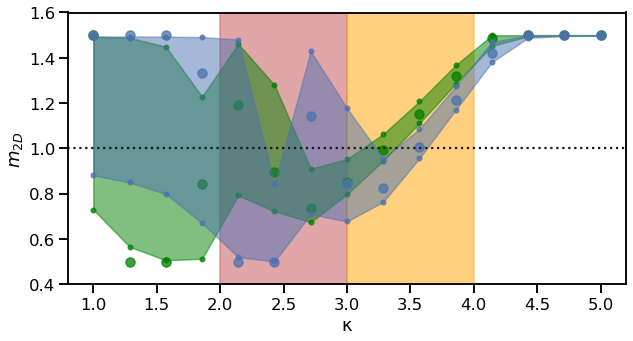

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))

#sig_E=1 / k_vel = k_dens
ax.fill_between(pd_1015.iloc[0], pd_1015.iloc[1]+pd_1015.iloc[2], pd_1015.iloc[1]-pd_1015.iloc[3], alpha = 0.5, color = 'green')
for i in range(len(data_in)):
    ax.scatter(data_1015[str(i)][0],data_1015[str(i)][1], color = 'green', marker = 'o', alpha = 0.75)
    ax.scatter(data_1015[str(i)][0],data_1015[str(i)][1] + data_1015[str(i)][2], color = 'green', marker = '.', alpha = 0.75)
    ax.scatter(data_1015[str(i)][0],data_1015[str(i)][1] - data_1015[str(i)][3], color = 'green', marker = '.', alpha = 0.75)
#sig_E=2 / k_vel = k_dens
ax.fill_between(pd_2015.iloc[0], pd_2015.iloc[1]+pd_2015.iloc[2], pd_2015.iloc[1]-pd_2015.iloc[3], alpha = 0.5, color = 'b')
for i in range(len(data_in)):
    ax.scatter(data_2015[str(i)][0],data_2015[str(i)][1], color = 'b', marker = 'o', alpha = 0.75)
    ax.scatter(data_2015[str(i)][0],data_2015[str(i)][1] + data_2015[str(i)][2], color = 'b', marker = '.', alpha = 0.75)
    ax.scatter(data_2015[str(i)][0],data_2015[str(i)][1] - data_2015[str(i)][3], color = 'b', marker = '.', alpha = 0.75)

ax.fill_between(np.linspace(2,3,100), 0.2, 3, alpha = 0.5, color = 'r', zorder =-5)
ax.fill_between(np.linspace(3,4,100), 0.2, 4, alpha = 0.5, color = 'orange', zorder =-5)


ax.hlines(1.0,0,6,linestyle=':')

ax.set(
    xlim=[0.8, 5.2], ylim=[0.40,1.6],
    xlabel=r"κ", ylabel=r"$ m_{2D}$ ",
)


In [10]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 5943.510845661163 seconds ---
